<a href="https://colab.research.google.com/github/HiImGabry/speech-recognition-representation-unica-dl/blob/issue-11/Filter_Banks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualizzare audio tramite Filter Banks

In questo notebook viene eseguita un’analisi degli audio tramite i Filter Banks. I Filter Banks sono un insieme di filtri utilizzati per decomporre un segnale audio in diverse bande di frequenza, consentendo un’analisi più dettagliata delle caratteristiche del segnale.
Per implementare i Filter Banks ed eseguire, in questo modo, un'analisi più dettagliata e sotto diversi punti di vista, ci siamo ispirati ad un articolo che tratta i Filter Banks sotto un'ottica teorica e una pratica.
L'articolo in questione è il seguente: https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html

Inoltre siamo partiti da una base del tutto teorica, per capire il funzionamento effetivo dei Filter Banks, citiamo per correttezza quindi anche il seguente articolo: http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/

@misc{fayek2016,
  title   = "Speech Processing for Machine Learning: Filter banks, Mel-Frequency Cepstral Coefficients (MFCCs) and What's In-Between",
  author  = "Haytham M. Fayek",
  year    = "2016",
  url     = "https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html"
}

##Importazione delle librerie necessarie

Importiamo le librerie necessarie per implementare correttamente i Filter Banks. Le librerie che vediamo importate sotto, sono tutte note tranne `scipy.fftpack`, dalla quale importiamo il modulo `dct`.
Il modulo importato ci servirà per eseguire delle Trasformazioni Discrete di Coseno.
Queste tipologie di Trasformazioni sono utilizzate specialmente nell'elaborazione del segnale e nella compressione dei dati.

In [9]:
#importo le librerie necessarie
import numpy as np
import scipy.io.wavfile
from scipy.fftpack import dct
import wave
import matplotlib.pyplot as plt

## Scarichiamo il dataset

Andiamo nuovamente ad importare il nostro dataset, che ci servirà per tutte le computazione successive alla seguente cella di codice.
Abbiamo già visto queste 3 linee di codice (le usa solo Theo perché lavora con Colab, quindi dobbiamo cambiarle perché non andremo ad importare il dataset in ogni nuovo notebook).

In [10]:
!wget --no-check-certificate 'https://cdn.discordapp.com/attachments/1209871752134529066/1249007689183268864/reduced_dataset.zip?ex=6667b6ce&is=6666654e&hm=ed971eaee27586811340cf43960d7599cf17c12a174bb2abb6bc0faa42cf7975&' -O ../reduced_dataset.zip
!unzip ../reduced_dataset.zip
!mv reduced_dataset ..

Streaming output truncated to the last 5000 lines.
  inflating: reduced_dataset/dataset/audio/right/b7a0754f_nohash_2.wav  
  inflating: reduced_dataset/dataset/audio/right/b83c1acf_nohash_4.wav  
  inflating: reduced_dataset/dataset/audio/right/b8c48ffb_nohash_1.wav  
  inflating: reduced_dataset/dataset/audio/right/b93528e3_nohash_0.wav  
  inflating: reduced_dataset/dataset/audio/right/b959cd0c_nohash_0.wav  
  inflating: reduced_dataset/dataset/audio/right/b97c9f77_nohash_0.wav  
  inflating: reduced_dataset/dataset/audio/right/b9f46737_nohash_2.wav  
  inflating: reduced_dataset/dataset/audio/right/b9f46737_nohash_3.wav  
  inflating: reduced_dataset/dataset/audio/right/ba59cab3_nohash_0.wav  
  inflating: reduced_dataset/dataset/audio/right/ba59cab3_nohash_1.wav  
  inflating: reduced_dataset/dataset/audio/right/bcdaa7a9_nohash_3.wav  
  inflating: reduced_dataset/dataset/audio/right/bd11a2e7_nohash_2.wav  
  inflating: reduced_dataset/dataset/audio/right/bdee441c_nohash_3.wav  


## "Vedere" un Audio

Con l'ausilio delle librerie sopra importate e con delle piccole traformazioni, diventa possibile "vedere" un Audio.
Infatti come vediamo nelle successive celle, andiamo a plottare le onde del segnale.
Prima di tutto andiamo a scegliere un audio dal nostro training set, dopodiché andiamo a definire tramite la funzione `scipy.io.wavfile.read(path)`, le due variabili `sample_rate` e `signal`, che ci serviranno per determinare partendo dall' Audio selezionato rispettivamente la frequenza di campionamento e un array che contiene i dati del segnale audio.

In [18]:
path = 'reduced_dataset/dataset/audio/yes/9f869f70_nohash_1.wav'
sample_rate, signal = scipy.io.wavfile.read(path) #determiniamo la frequenza di campionamento e i dati del segnale audio

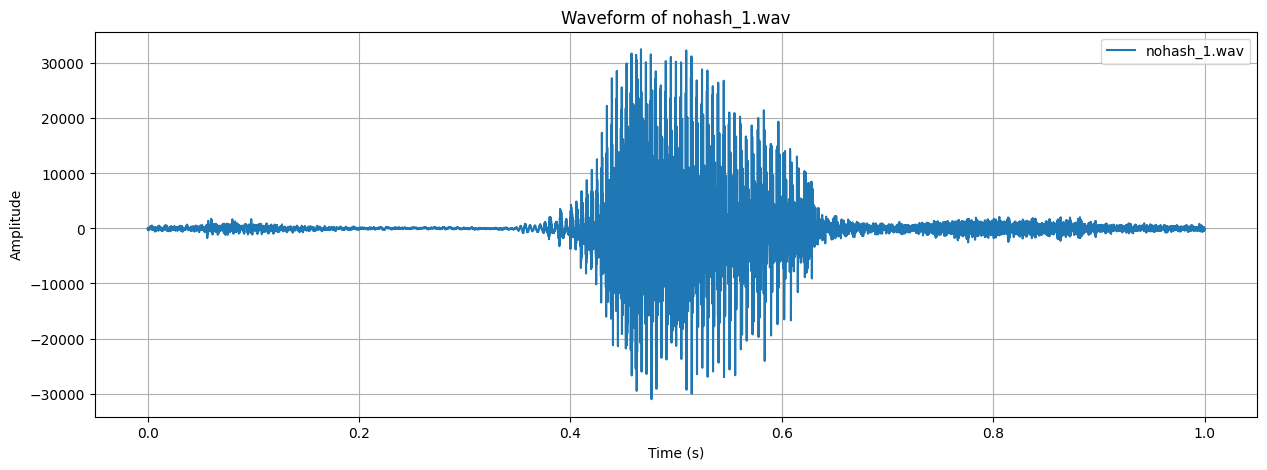

In [19]:
temporal_val = np.arange(len(signal)) / float(sample_rate) #con questa riga di codice andiamo a creare un array che contiene i valori temporali (in secondi) per ciascun campione del segnale audio.

audio = wave.open(path, "r").readframes(-1) #mediante la funzione wave.open prendiamo i frame dell'audio
#audio = np.frombuffer(audio, dtype=np.int16) #con questa riga di codice andiamo a convertire tutti i valori in int a 16bit

#plottiamo il nostro audio ponendo sull'asse y l'ampiezza (Amplitude) e sull'asse x il tempo in secondi (Time (s))
plt.figure(figsize=(15, 5))
plt.plot(temporal_val, signal, label='nohash_1.wav')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Waveform of nohash_1.wav')
plt.legend()
plt.grid(True)
plt.show()

## Pre-Emphasis Phase

Prima di creare i nostri Filter Banks, andiamo ad applicare un filtro di "Pre-Emphasis" sul segnale per amplificare le alte frequenze. Questo passaggio ci permette di ridurre anche l’effetto del rumore di fondo, migliorando così l'accuratezza delle successive analisi e trasformazioni. Per determinare quanto le frequenze alte del segnale vengano amplificate rispetto alle basse frequenze abbiamo utilizzato un coefficiente di `pre-emphasis` pari a 0,97.
Questa fase può avere diversi scopi, infatti il filtro di `pre-emphasis`, può essere utilizzato per:
*   Bilanciare lo spettro delle alte frequenze
*   Evitare problemi numerici durante l'operazione di trasformata di Fourier (che vedremo dopo)
*   Migliorare il rapporto SNR (Signal-to-Noise Ratio)

L'equazione utilizzata per applicare ad un segnale audio $x$, il filtro di pre-emphasis è la seguente:

$y(t)=x(t)−αx(t−1)$


Come possiamo notare, il grafico nella cella di output successiva, il grafico relativo all'audio `nohash_1.wav`, cambia notevolmente e possiamo addirittura vedere come l'Audio sembra essere più "pulito", per via del bilanciamento delle alte frequenze.


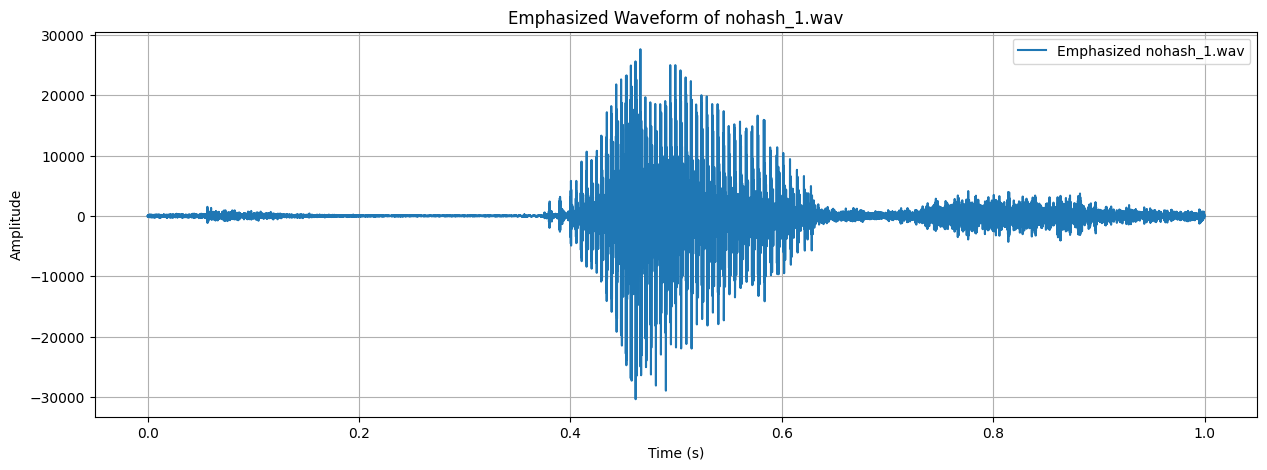

In [25]:
pre_emphasis = 0.97
emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

plt.figure(figsize=(15, 5))
plt.plot(temporal_val, emphasized_signal, label='Emphasized nohash_1.wav')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Emphasized Waveform of nohash_1.wav')
plt.legend()
plt.grid(True)
plt.show()

## Framing Phase

Ora abbiamo bisogno di dividere l'audio in frames di breve durata. Questo processo viene eseguito perché risulta noto che un segnale audio cambi molto frequentemente durante il tempo, questo lo si può facilmente evincere anche dal grafico riportato sopra.
Proprio per questo motivo nella maggior parte delle casistiche non è una buona idea eseguire la Trasformata di Fourier per tutto il segnale audi. A questo proposito assumiamo che in un piccolissimo periodo di tempo le frequenze considerate siano stabili, eseguendo una sorta di approssimazione sulle fequenze del nostro audio.

Per quanto riguarda la vera e propria "Segmentazione" (Framing) del nostro segnale audio, andiamo ad adottare degli standard tipici, che vengono solitamente impegati per il processamento del linguaggio e sono:
*   `frame_size = 0.025`
*   `frame_stride = 0.01`

Dove `frame_size` indica la dimensione del frame ovvero 25 ms e `frame_stride` indica dopo quanti millisecondi inizierà il successivo frame.
Facciamo un esempio per rendere il concetto più chiaro ed evitare di creare dubbi/confusione.
La nostra frame_size è pari a 25 ms, con un frame_stride di 10 ms, significa che ogni nuovo frame inizierà 10 ms dopo l'inizio del precedente (questo concetto viene definito 'overlap') e nel nostro caso possiamo affermare di avere 15 ms di overlap.



In [42]:
frame_size = 0.025
frame_stride = 0.01

frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convertiamo da secondi a samples
signal_length = len(emphasized_signal)
# Per rendere il calcolo più agevole le due variabili vengono convertite e arrotondate in numeri interi
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))

num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  #Il numero di frame viene calcolato come il rapporto tra la lunghezza effettiva del segnale e il singolo step
#in questo modo siamo sicuri che ci sia almeno un frame anche se il segnale è più corto di frame_length

pad_signal_length = num_frames * frame_step + frame_length
z = np.zeros((pad_signal_length - signal_length))
pad_signal = np.append(emphasized_signal, z) # Pad Signal serve per essere sicuri che tutti i samples abbiano la stessa lunghezza

indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(np.int32, copy=False)]

## Finestra di Hamming

Dopo aver suddiviso i segnali audio in frame (quindi averli campionati), andiamo ad applicare una funzione particolare, chiamata "Funzione Finestra", nel nostro caso applichiamo nello specifico la Hamming Window, espressa con la seguente:
Devo aggiungere la formula

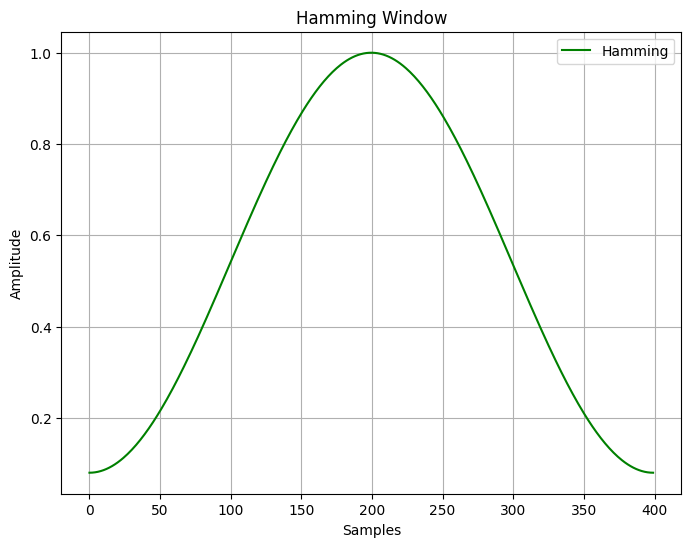

In [41]:
frames *= np.hamming(frame_length)
#frames *= 0.54 - 0.46 * np.cos((2 * np.pi * 3) / (frame_length - 1))

hamming_window = np.hamming(frame_length)

# Crea il grafico
plt.figure(figsize=(8, 6))
plt.plot(hamming_window, label='Hamming', color='green')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('Hamming Window')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
NFFT = 512 #oppure 512
mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

MEL min: 0
MEL max: 2840.023046708319


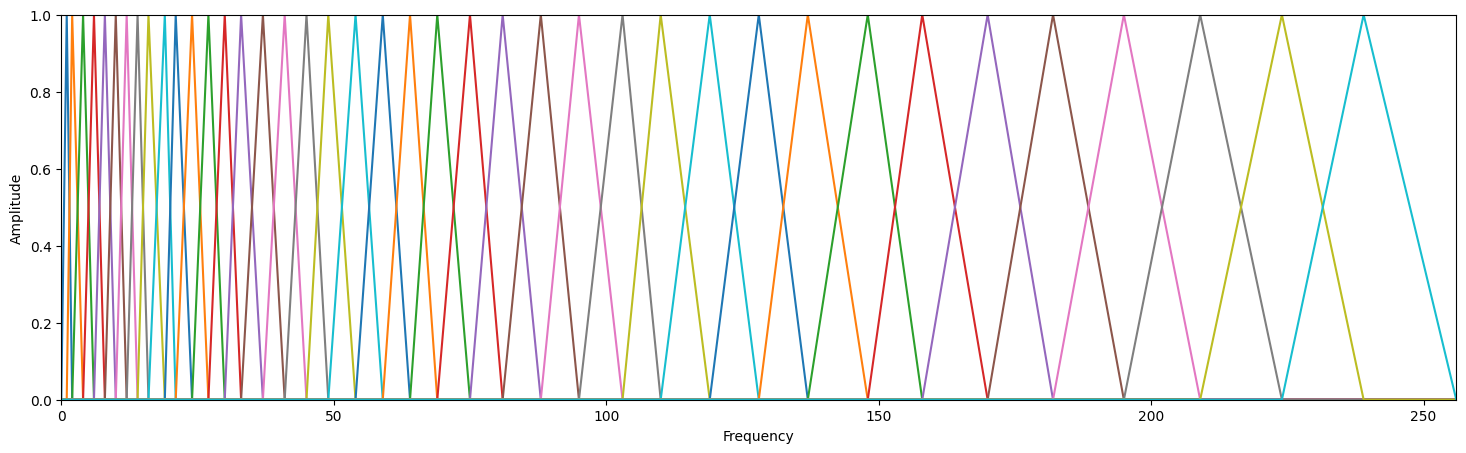

In [29]:
nfilt = 40
low_freq_mel = 0
high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = np.floor((NFFT + 1) * hz_points / sample_rate)

print("MEL min: {0}".format(low_freq_mel))
print("MEL max: {0}".format(high_freq_mel))

fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = np.dot(pow_frames, fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * np.log10(filter_banks)  # dB

plt.figure(figsize=(18,5))
for n in range(fbank.shape[0]):
    plt.plot(fbank[n])
    plt.margins(x=0)
    plt.margins(y=0)
    plt.ylabel('Amplitude')
    plt.xlabel('Frequency')